# **Gradient Boosting Regression**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
sns.set()

# Algorithm with an Example
Gradient boosting is one of the variants of ensemble methods where you create multiple weak models and combine them to get better performance as a whole.
In this section, we are building gradient boosting regression trees step by step using the below sample which has a nonlinear relationship between x and y to intuitively understand how it works.

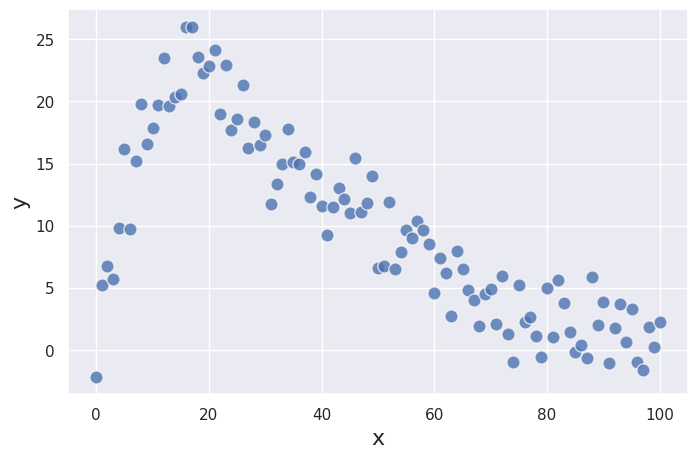

In [2]:
np.random.seed(123)
x = np.linspace(0, 100, 101)
# generating y using gamma distribution
y = (stats.gamma.pdf(x, a=2, loc=0, scale=17) + np.random.normal(0,0.002,101)) * 1000
x = x.reshape(-1,1)

plt.rcParams["figure.figsize"] = (8, 5)
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()

The first step is making a very naive prediction on the target y. We make the initial prediction F₀ as an overall average of y:

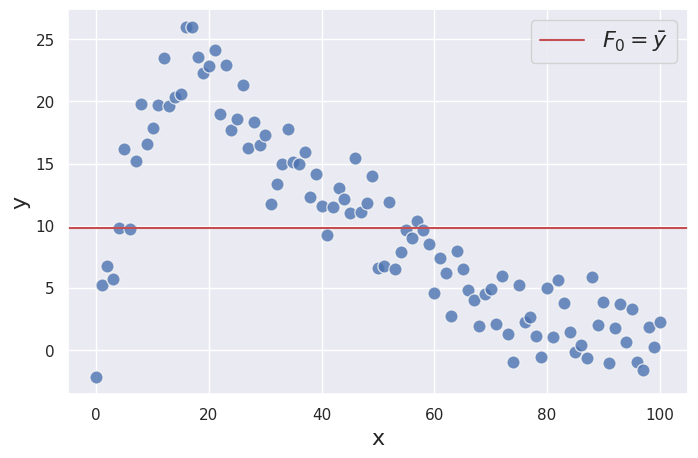

In [3]:
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.axhline(y=y.mean(), color='r', linestyle='-', label=r'$F_{0} = \bar{y}$')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=16)
plt.show()

You might feel using the mean for the prediction is silly, but don't worry. We will improve our prediction as we add more weak models to it.
To improve our prediction, we will focus on the residuals (i.e. prediction errors) from the first step because that is what we want to minimize to get a better prediction. The residuals r₁ are shown as the vertical blue lines in the figure below.

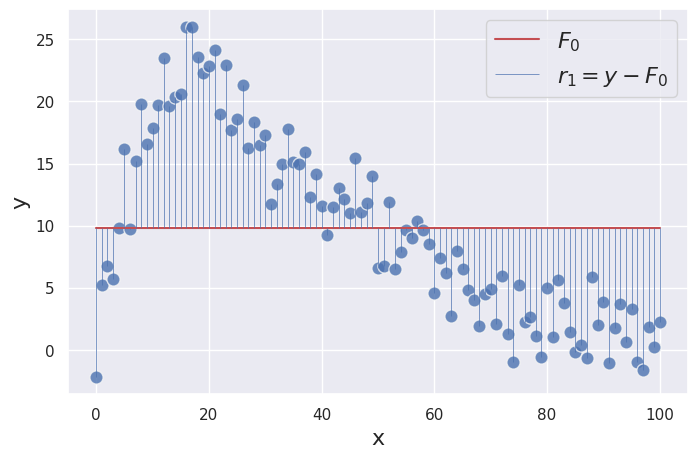

In [4]:
def plot_residuals(x, y, Fm, i, ax, title = ""):
    fltr_smaller = y < Fm
    fltr_bigger = y >= Fm

    ax.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
    ax.plot(x, Fm, c='r', label=f'$F_{i}$')
    ax.vlines(x[fltr_smaller], y[fltr_smaller], Fm[fltr_smaller], linewidth=0.5, color='b', label=f'$r_{i+1} = y - F_{i}$')
    ax.vlines(x[fltr_bigger], Fm[fltr_bigger], y[fltr_bigger], linewidth=0.5, color='b')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.legend(fontsize=16)

fig, ax = plt.subplots(1, 1)
F0 = np.full(len(y), y.mean())
plot_residuals(x, y, F0, 0, ax)
plt.show()

To minimize these residuals, we are building a regression tree model with x as its feature and the residuals r = y − mean(y) as its target. The reasoning behind that is if we can find some patterns between x and r by building the additional weak model, we can reduce the residuals by utilizing it.
To simplify the demonstration, we are building very simple trees each of that only has one split and two terminal nodes which is called "stump". Please note that gradient boosting trees usually have a little deeper trees such as ones with 8 to 32 terminal nodes.
Here we are creating the first tree predicting the residuals with two different values γ₁ = {6.0, −5.9} (we are using γ(gamma) to denotes the prediction).

In [5]:
# this function print out tree structures (adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)
def print_tree(clf):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print('-' * 80)
    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node.".format(
                    space=node_depth[i] * "\t", node=i
                )
            )
            print(node_depth[i] * '\t', f"prediction: {clf.tree_.value[i, 0, 0]:.1f}")
        else:
            print(
                "{space}node={node} is a split node: "
                "go to node {left} if X[:, {feature}] <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature[i],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )
    print('-'*80)

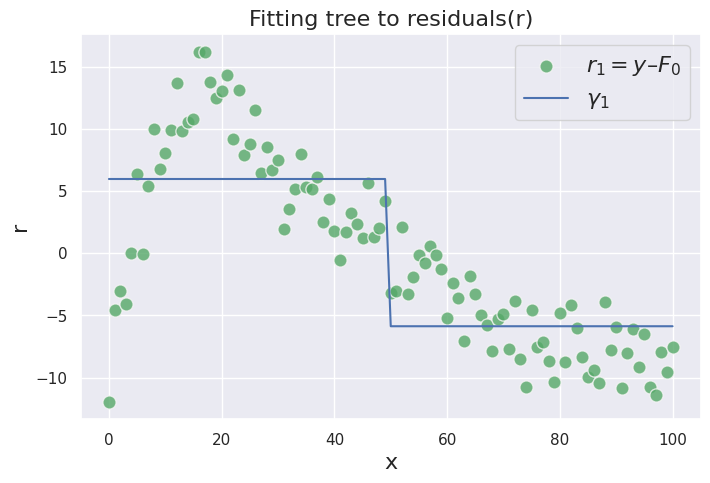

--------------------------------------------------------------------------------
The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 49.5 else to node 2.
	node=1 is a leaf node.
	 prediction: 6.0
	node=2 is a leaf node.
	 prediction: -5.9
--------------------------------------------------------------------------------


In [6]:
def train_and_update(x, y, Fm, learing_rate=0.1):
    r = y - Fm
    tree = DecisionTreeRegressor(max_depth=1, random_state=0)
    tree.fit(x, r)
    gamma = tree.predict(x)
    Fm = Fm + learing_rate * gamma
    return tree, Fm, gamma, r

def plot_gamma(x, residuals, gamma, i, ax, title = ""):
    ax.scatter(x, residuals, edgecolors='whitesmoke', color = 'g', s=90, alpha=0.8, label=f'$r_{i} = y – F_{i-1}$')
    ax.plot(x, gamma, c='b', label=f'$γ_{i}$')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("x", fontsize=16)
    ax.set_ylabel("r", fontsize=16)
    ax.legend(fontsize=16)

tree, Fm, gamma, r = train_and_update(x, y, F0, learing_rate=0.9)
fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 1, ax, "Fitting tree to residuals(r)")
plt.show()
print_tree(tree)

This prediction γ₁ is added to our initial prediction F₀ to reduce the residuals. In fact, gradient boosting algorithm does not simply add γ to F as it makes the model overfit to the training data. Instead, γ is scaled down by **learning rate** ν which ranges between 0 and 1, and then added to F.

$$F₁ = F₀ + ν∙γ₁$$

In this example, we use a relatively big learning rate ν = 0.9 to make the optimization process easier to understand, but it is usually supposed to be a much smaller value such as 0.1.
After the update, our combined prediction F₁ becomes:

$$
F₁ = \begin{cases}
    F₀+ν∙6.0 & \text{if } x≤49.5 \\
    F₀-ν∙5.9 & \text{otherwise}
\end{cases}
$$

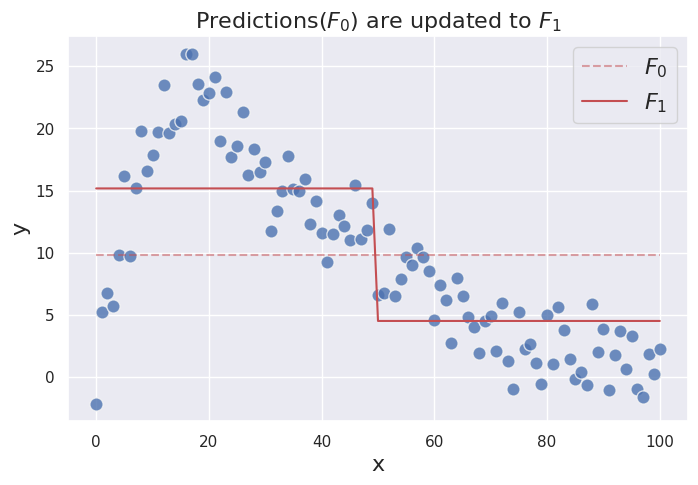

In [7]:
def plot_update(x, y, Fm, Fm_pre, i):
    plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
    plt.plot(x, Fm_pre, c='r', linestyle='--', label=f'$F_{i-1}$', alpha=0.5)
    plt.plot(x, Fm, c='r', label=f'$F_{i}$')
    plt.title(f"Predictions($F_{i-1}$) are updated to $F_{i}$", fontsize=16)
    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

plot_update(x, y, Fm, F0, 1)

Now, the updated residuals r₂ looks like this:

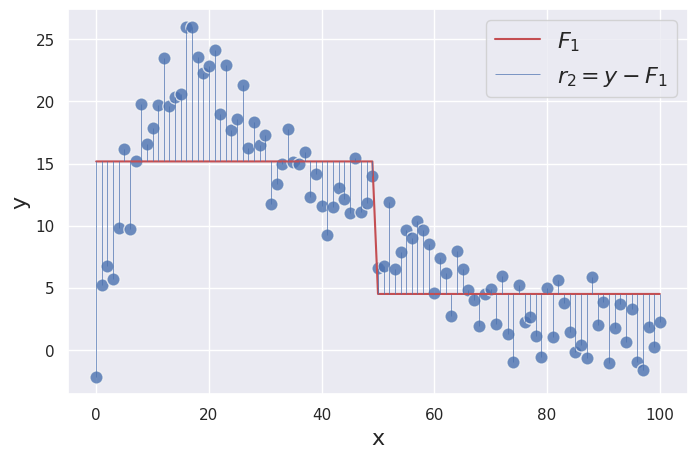

In [8]:
fig, ax = plt.subplots(1, 1)
plot_residuals(x, y, Fm, 1, ax)
plt.show()

In the next step, we are creating a regression tree again using the same x as the feature and the updated residuals r₂ as its target. Here is the created tree:

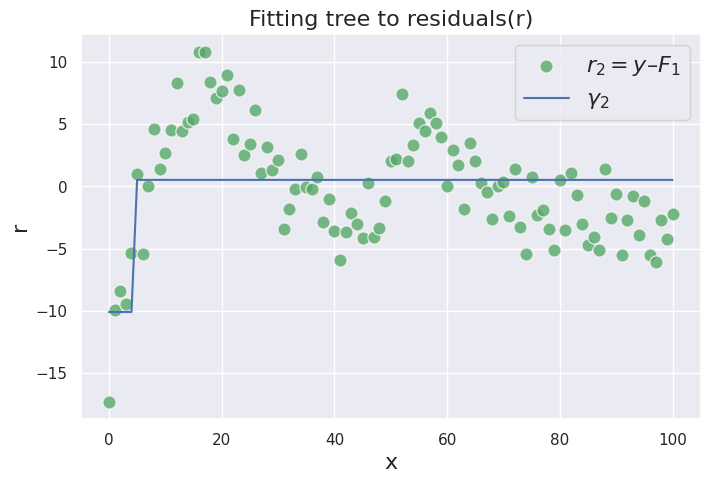

--------------------------------------------------------------------------------
The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 4.5 else to node 2.
	node=1 is a leaf node.
	 prediction: -10.1
	node=2 is a leaf node.
	 prediction: 0.5
--------------------------------------------------------------------------------


In [9]:
Fm_pre = Fm.copy()
tree, Fm, gamma, r = train_and_update(x, y, Fm, learing_rate=0.9)

fig, ax = plt.subplots(1, 1)
plot_gamma(x, r, gamma, 2, ax, "Fitting tree to residuals(r)")
plt.show()
print_tree(tree)

Then, we are updating our previous combined prediction F₁ with the new tree prediction γ₂.

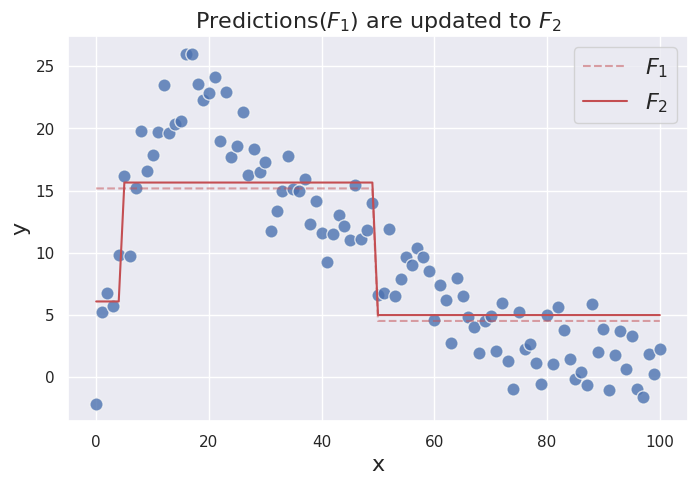

In [10]:
plot_update(x, y, Fm, Fm_pre, 2)

We iterate these steps until the model prediction stops improving. The figures below show the optimization process from 0 to 6 interactions.

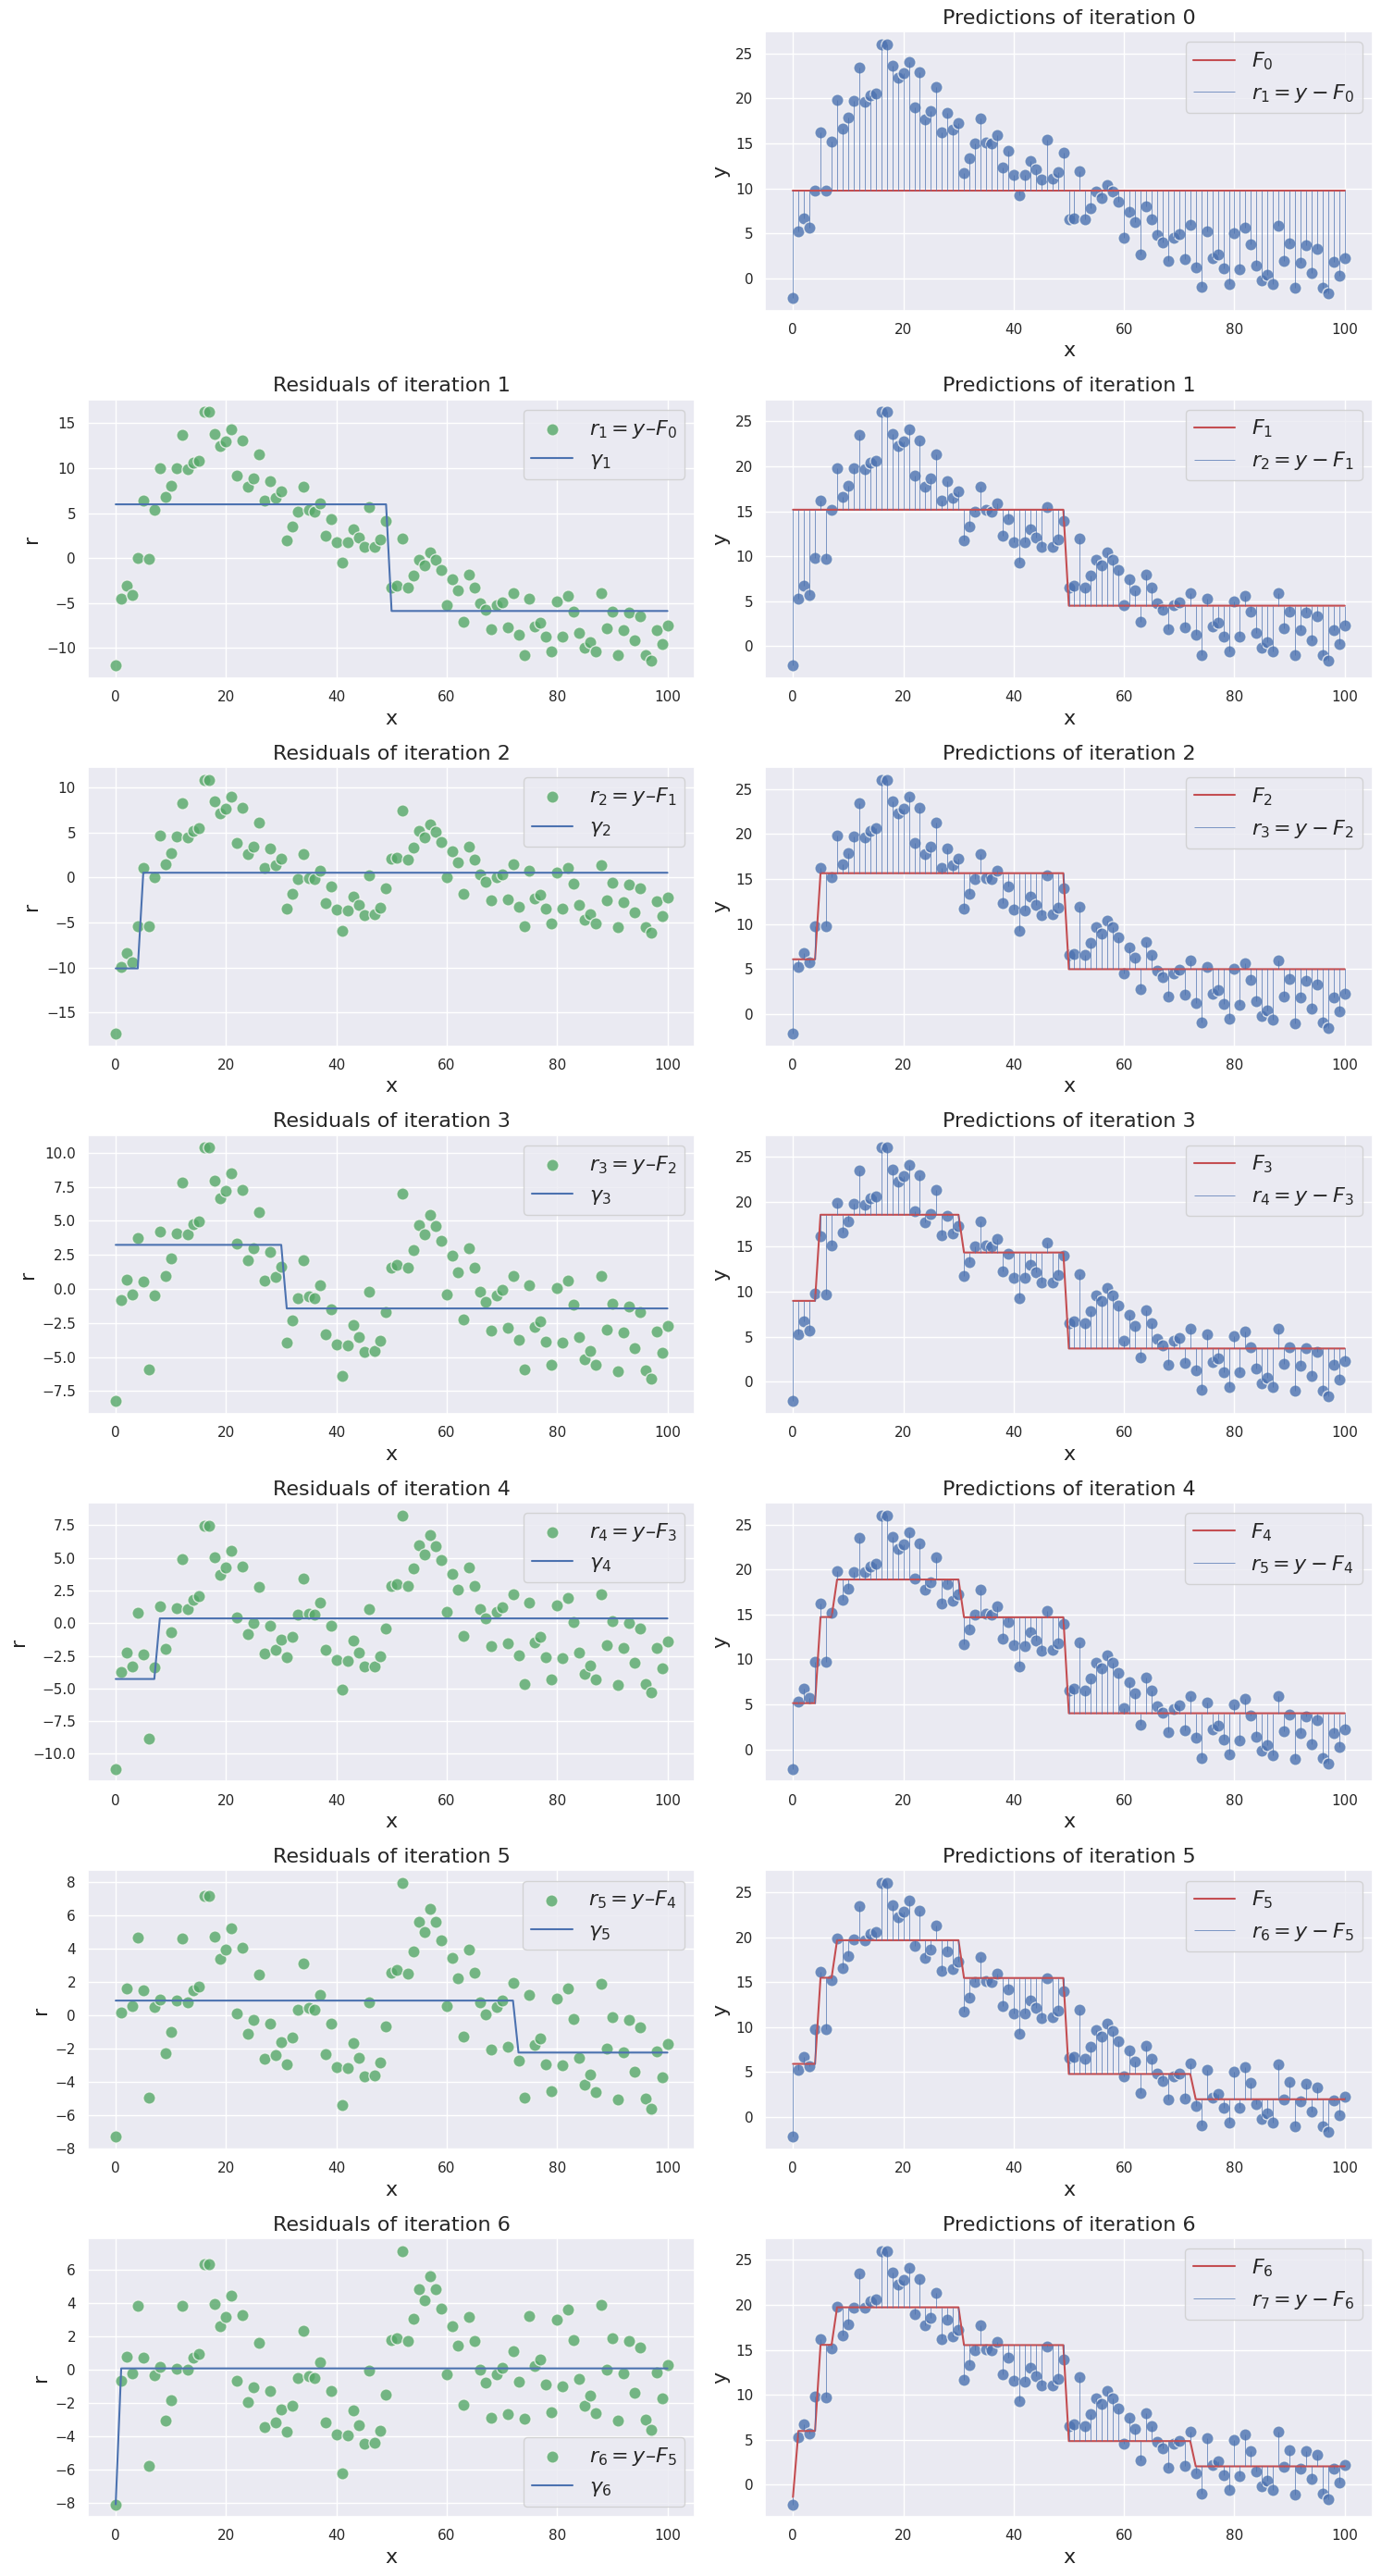

In [11]:
Fm = F0 = np.full(len(y), y.mean())
n_estimators = 6

fig, axs = plt.subplots(n_estimators+1, 2, figsize=(15, 4*(n_estimators+1)))
axs = axs.flatten()
axs[0].axis('off')

plot_residuals(x, y, F0, 0, axs[1], title="Predictions of iteration 0")

for i in range(n_estimators):
    tree, Fm, gamma, r = train_and_update(x, y, Fm, learing_rate=0.9)
    j = 2 + i * 2
    plot_gamma(x, r, gamma, i+1, axs[j], f"Residuals of iteration {i+1}")
    plot_residuals(x, y, Fm, i+1, axs[j+1], title=f"Predictions of iteration {i+1}")

plt.tight_layout()
plt.show()

# Code
In this section, we are translating the maths we just reviewed into a viable python code to help us understand the algorithm further. The code is mostly derived from [Matt Bowers' implementation](https://blog.mattbowers.dev/gradient-boosting-machine-from-scratch#Implementation), so all credit goes to his work. We are using DecisionTreeRegressor from scikit-learn to build trees which helps us just focus on the gradient boosting algorithm itself instead of the tree algorithm. We are imitating scikit-learn style implementation where you train the model with fit method and make predictions with predict method.

In [12]:
class CustomGradientBoostingRegressor:
    def __init__(self, learning_rate, n_estimators, max_depth=1):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.F0 = y.mean()
        Fm = self.F0
        for _ in range(self.n_estimators):
            r = y - Fm
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=0)
            tree.fit(X, r)
            gamma = tree.predict(X)
            Fm += self.learning_rate * gamma
            self.trees.append(tree)

    def predict(self, X):
        Fm = self.F0
        for i in range(self.n_estimators):
            Fm += self.learning_rate * self.trees[i].predict(X)
        return Fm

Please note that all the trained trees are stored in self.trees list object and it is retrieved when we make predictions with predict method.


Next, we are checking if our CustomGradientBoostingRegressor performs as the same as GradientBoostingRegressor from scikit-learn.

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

custom_gbm = CustomGradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=1
)
custom_gbm.fit(x, y)
mse = mean_squared_error(y, custom_gbm.predict(x))
custom_gbm_rmse = np.sqrt(mse)
print(f"Custom GBM RMSE: {custom_gbm_rmse:.15f}")

sklearn_gbm = GradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=1
)
sklearn_gbm.fit(x, y)
mse = mean_squared_error(y, sklearn_gbm.predict(x))
sklearn_gbm_rmse = np.sqrt(mse)
print(f"Scikit-learn GBM RMSE: {sklearn_gbm_rmse:.15f}")

Custom GBM RMSE: 3.961707263264281
Scikit-learn GBM RMSE: 3.961707263264281


As you can see in the output above, both models have exactly the same RMSE.